In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-12-04 00:00:00-05:00', '2023-12-05 00:00:00-05:00',
               '2023-12-06 00:00:00-05:00', '2023-12-07 00:00:00-05:00',
               '2023-12-08 00:00:00-05:00', '2023-12-11 00:00:00-05:00',
               '2023-12-12 00:00:00-05:00', '2023-12-13 00:00:00-05:00',
               '2023-12-14 00:00:00-05:00', '2023-12-15 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24106, freq=None)

<Axes: xlabel='Date'>

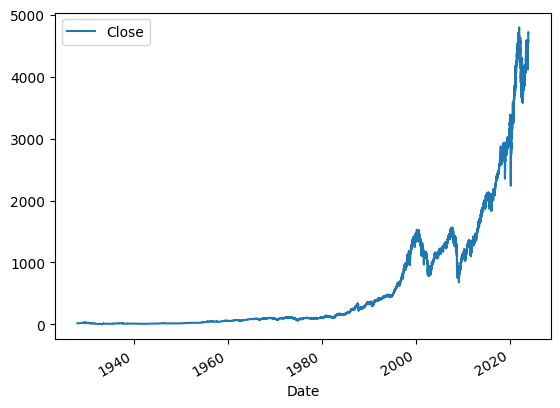

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
sp500["Tommorow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tommorow"] > sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,Tommorow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-12-11 00:00:00-05:00,4593.390137,4623.709961,4593.390137,4622.439941,3823210000,4643.700195,1
2023-12-12 00:00:00-05:00,4618.299805,4643.930176,4608.089844,4643.700195,3808380000,4707.089844,1
2023-12-13 00:00:00-05:00,4646.200195,4709.689941,4643.229980,4707.089844,5063650000,4719.549805,1


In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
preds

Date
2023-07-27 00:00:00-04:00    1
2023-07-28 00:00:00-04:00    0
2023-07-31 00:00:00-04:00    0
2023-08-01 00:00:00-04:00    0
2023-08-02 00:00:00-04:00    1
                            ..
2023-12-11 00:00:00-05:00    1
2023-12-12 00:00:00-05:00    1
2023-12-13 00:00:00-05:00    0
2023-12-14 00:00:00-05:00    0
2023-12-15 00:00:00-05:00    0
Length: 100, dtype: int32

In [12]:
precision_score(test["Target"], preds)

0.4925373134328358

<Axes: xlabel='Date'>

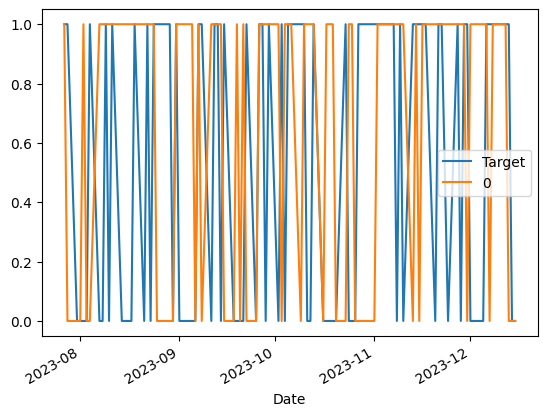

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
    

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

Predictions
0    3460
1    2596
Name: count, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534181
0    0.465819
Name: count, dtype: float64

In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [21]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [22]:
sp500

,Open,High,Low,Close,Volume,Tommorow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,4622.439941,1,1.002044,2.0,1.006364,2.0,1.050697,33.0,1.087021,132.0,1.165591,528.0
2023-12-11 00:00:00-05:00,4593.390137,4623.709961,4593.390137,4622.439941,3823210000,4643.700195,1,1.001958,2.0,1.007993,3.0,1.054130,34.0,1.090636,132.0,1.169745,528.0
2023-12-12 00:00:00-05:00,4618.299805,4643.930176,4608.089844,4643.700195,3808380000,4707.089844,1,1.002294,2.0,1.009261,4.0,1.058214,34.0,1.095008,132.0,1.174703,528.0


In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [25]:
predictions = backtest(sp500, model, new_predictors)

In [26]:
predictions["Predictions"].value_counts()

Predictions
0.0    4225
1.0     830
Name: count, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.572289156626506

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544016
0    0.455984
Name: count, dtype: float64

In [29]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2023-12-08 00:00:00-05:00,1,0.0
2023-12-11 00:00:00-05:00,1,0.0
2023-12-12 00:00:00-05:00,1,0.0
